<a href="https://colab.research.google.com/github/jeenraju/Projects/blob/main/RP_UpdatedLoss_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary Packages**

In [3]:
import torch
from torchvision.datasets import MNIST, USPS, SVHN
from torchvision.transforms import Compose, Resize, ToTensor, Grayscale
from torch.utils.data import DataLoader

from torch import nn
from torch import optim
import random
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

**Dataset downloading and loading**

In [4]:
BATCH_SIZE = 200
IMAGE_RESCALE = 28
def get_data_loaders():
    transform_mnist_usps = Compose([
        Resize((IMAGE_RESCALE, IMAGE_RESCALE)),
        ToTensor()
    ])

    transform_svhn = Compose([
        Resize((IMAGE_RESCALE, IMAGE_RESCALE)),
        Grayscale(num_output_channels=1),  # Convert SVHN (RGB) to Grayscale
        ToTensor()
    ])

    # MNIST - Source Domain
    mnist_train = MNIST(root="./data", train=True, transform=transform_mnist_usps, download=True)
    mnist_test = MNIST(root="./data", train=False, transform=transform_mnist_usps, download=True)

    # USPS - Target Domain
    usps_train = USPS(root="./data", train=True, transform=transform_mnist_usps, download=True)
    usps_test = USPS(root="./data", train=False, transform=transform_mnist_usps, download=True)

    # SVHN - Additional Target Domain
    svhn_train = SVHN(root="./data", split='train', transform=transform_svhn, download=True)
    svhn_test = SVHN(root="./data", split='test', transform=transform_svhn, download=True)

    loaders = {
        'mnist_train': DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True),
        'mnist_test': DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False),
        'usps_train': DataLoader(usps_train, batch_size=BATCH_SIZE, shuffle=True),
        'usps_test': DataLoader(usps_test, batch_size=BATCH_SIZE, shuffle=False),
        'svhn_train': DataLoader(svhn_train, batch_size=BATCH_SIZE, shuffle=True),
        'svhn_test': DataLoader(svhn_test, batch_size=BATCH_SIZE, shuffle=False)
    }
    return loaders

#Load Data
loaders = get_data_loaders()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.43MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 6.58M/6.58M [00:00<00:00, 15.8MB/s]


100%|██████████| 1.83M/1.83M [00:00<00:00, 5.12MB/s]


100%|██████████| 182M/182M [01:09<00:00, 2.63MB/s]


100%|██████████| 64.3M/64.3M [00:31<00:00, 2.02MB/s]


**Weighted Probability function**

In [5]:
def weighted_probability(masks, logit):

    # Step 1: Combine masks and logit
    masks_logit = torch.cat([masks, logit], dim=1)  # Shape: (batch_size, num_masks + 1)

    # Step 2: Count occurrences of each value in the masks and logit
    occurances = torch.zeros_like(masks_logit)
    for i in range(masks_logit.shape[1]):
        occurances[:, i] = (masks_logit == masks_logit[:, i].unsqueeze(1)).sum(dim=1)

    # Constants
    k = torch.exp(torch.tensor(1.0)) + 1e-5  # Combined constant
    bias = 1e-3  # Small bias term to ensure the logit's weight is slightly greater

    # Step 3: Compute mean (μ) and standard deviation (σ) of masks
    mu = masks.mean(dim=1, keepdim=True)  # (batch_size, 1)
    # sigma = masks.std(dim=1, keepdim=True) + 1e-5  # Prevent NaN

    # Step 4: Compute initial weights for the masks
    d_i = torch.abs(masks - mu)  # Distance from mean
    w_masks = 1 / (torch.log(d_i + k))

    # Step 5: Compute initial weight for the logit
    d_u = torch.abs(logit - mu)
    w_logit = 1 / (torch.log(d_u + k + bias))  # Add bias directly

    # Ensure logit weight is slightly greater if equal to mean
    is_mean = (logit == mu) & (masks == mu).any(dim=1, keepdim=True)
    w_logit += is_mean.float() * 0.01  # Slightly increase logit weight

    # Step 6: Normalize the weights
    S = w_masks.sum(dim=1, keepdim=True) + w_logit
    w_i = w_masks / S
    w_u = w_logit / S

    # Step 7: Compute weighted probability
    Pr_w_masks = w_i * occurances[:, :-1]  # Exclude logit column
    Pr_w_logit = w_u * occurances[:, -1:]  # Last column is logit

    # Normalize weighted probabilities
    S_final = Pr_w_masks.sum(dim=1, keepdim=True) + Pr_w_logit
    Pr_w_masks /= S_final
    Pr_w_logit /= S_final

    # Step 8: Concatenate results
    Pr_w_MaksLogits = torch.cat([Pr_w_masks, Pr_w_logit], dim=1)  # (batch_size, num_masks + 1)

    return Pr_w_MaksLogits


**Prospect Certainty function**

In [6]:
def prospect_certainty(masks_logits, Pr_w_MaksLogits):

    alpha = 0.88  # Parameter for the value function
    gamma = 0.61  # Parameter for the probability weighting function

    value_function = torch.pow(torch.clamp(masks_logits, min=0), alpha)  # Only for x >= 0

    weighted_probability = torch.pow(Pr_w_MaksLogits, gamma) / torch.pow(
        torch.pow(Pr_w_MaksLogits, gamma) + torch.pow(1 - Pr_w_MaksLogits, gamma), 1 / gamma
    )

    PCI = weighted_probability * value_function  # Element-wise multiplication

    return PCI



**Model Architecture**

In [7]:
class CNNEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    # Input: 1 x 28 x 28; Output: 20 x 12 x 12
    self.conv1 = nn.Sequential(nn.Conv2d(1, 20, kernel_size=5), nn.MaxPool2d(kernel_size=2), nn.ReLU())
    # Input: 20 x 12 x 12; Output: 50 x 4 x 4
    self.conv2 = nn.Sequential(nn.Conv2d(20, 50, kernel_size=5), nn.Dropout2d(), nn.MaxPool2d(kernel_size=2), nn.ReLU())
    self.fc = nn.Linear(50 * 4 * 4, 500)

  def forward(self, x):
    x = self.conv2(self.conv1(x)).view(x.size(0), -1)
    return self.fc(x)

class EncoderWithClassifier(nn.Module):
    def __init__(self, num_masks, connection_ratios):
        super(EncoderWithClassifier, self).__init__()
        self.num_masks = num_masks
        self.connection_ratios = connection_ratios

        self.encoder = CNNEncoder()
        self.classifier = nn.Linear(500, 10)  # Original logits (10 classes)

        self.mask_transforms = nn.ModuleList([
            nn.Linear(int(ratio * 500), 1) for ratio in connection_ratios
        ])

        self.selected_indices_per_epoch = None

    def forward(self, x):
        hidden_output = self.encoder(x)
        logits = self.classifier(hidden_output)

        final_pci_values, pci_values, selected_logits = self.apply_logit_masking(logits, hidden_output)
        return final_pci_values, pci_values, selected_logits

    def sample_indices_for_epoch(self, batch_size, num_nodes):
        self.selected_indices_per_epoch = []
        for logit_index in range(10):  # 10 logits
            per_logit_indices = [
                random.sample(range(num_nodes), int(self.connection_ratios[mask_idx] * num_nodes))
                for mask_idx in range(self.num_masks)
            ]
            self.selected_indices_per_epoch.append(per_logit_indices)

    def apply_logit_masking(self, logits, previous_layer_output):
        batch_size, num_logits = logits.shape
        _, num_nodes = previous_layer_output.shape
        selected_logits = []
        selected_Pr_w = []
        pci_values = []

        if self.selected_indices_per_epoch is None:
            self.sample_indices_for_epoch(batch_size, num_nodes)

        for logit_index in range(num_logits):  # Loop over each logit
            masks = []
            for mask_index in range(self.num_masks):
                selected_indices = self.selected_indices_per_epoch[logit_index][mask_index]  # Fixed per epoch
                selected_values = previous_layer_output[:, selected_indices]
                mask_value = self.mask_transforms[mask_index](selected_values)
                masks.append(mask_value)

            masks = torch.cat(masks, dim=1)  # Shape: (batch_size, num_masks)
            masks_logits = torch.cat([masks, logits[:, logit_index:logit_index+1]], dim=1)

            Pr_w = weighted_probability(masks_logits[:, :-1], masks_logits[:, -1:])

            max_idx = torch.argmax(Pr_w, dim=1, keepdim=True)
            best_logit_mask = masks_logits.gather(1, max_idx)
            Pr_w_selected = Pr_w.gather(1, max_idx)

            selected_logits.append(best_logit_mask)
            selected_Pr_w.append(Pr_w_selected)

        selected_logits = torch.cat(selected_logits, dim=1)
        selected_Pr_w = torch.cat(selected_Pr_w, dim=1)

        pci_values = prospect_certainty(selected_logits, selected_Pr_w)

        best_pci_idx = torch.argmax(pci_values, dim=1, keepdim=True)  # Shape: (batch_size, 1)
        final_selected_logits = torch.zeros_like(selected_logits)  # (batch_size, 10)
        final_selected_logits.scatter_(1, best_pci_idx, selected_logits.gather(1, best_pci_idx))
        final_pci_values = torch.zeros_like(pci_values)
        final_pci_values.scatter_(1, best_pci_idx, pci_values.gather(1, best_pci_idx))

        # Normalize PCI to [0,1] by dividing by the max
        max_pci = final_pci_values.max(dim=1, keepdim=True)[0] + 1e-8  # Add small epsilon for stability
        PCI_normalized = final_pci_values / max_pci

        return final_pci_values, PCI_normalized, final_selected_logits



**Loss function**

In [8]:
class BarrierConstrainedLoss(nn.Module):
    def __init__(self, num_classes=10, initial_mu=1.0, mu_decay=0.95, min_mu=0.01, epsilon=0.5):
        super(BarrierConstrainedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        self.mu = initial_mu  # Barrier function parameter
        self.mu_decay = mu_decay  # Decay rate for mu (0 < decay < 1)
        self.min_mu = min_mu  # Minimum value for mu
        self.epsilon = epsilon  # Small threshold for PCI values

    def forward(self, predictions, targets, pci_values):
        # Standard Cross-Entropy Loss
        ce_loss = self.cross_entropy(predictions, targets)

        num_classes = predictions.shape[1]  # Dynamically get the number of classes
        max_ce = torch.log(torch.tensor(num_classes, dtype=torch.float, device=ce_loss.device)).detach()
        normalized_loss = ce_loss / max_ce

        # Ensure pci_values > epsilon to avoid log issues
        safe_pci_values = torch.clamp(pci_values, min=self.epsilon + 1e-6)

        # Compute barrier function constraint
        constraint = self.mu * torch.log(safe_pci_values - self.epsilon).mean()

        # Final constrained loss
        constrained_loss = ce_loss - constraint

        return constrained_loss

    def update_mu(self):
        """
        Gradually decrease the barrier parameter (mu) over iterations.
        """
        self.mu = max(self.mu * self.mu_decay, self.min_mu)  # Ensure it does not go below min_mu


**Save Load Model Parameters**

In [9]:
def save_model(model, path="model_MNIST.pth"):
    torch.save({
        'encoder_state_dict': model.encoder.state_dict(),
        'classifier_state_dict': model.classifier.state_dict(),
        'mask_transforms_state_dict': [mask.state_dict() for mask in model.mask_transforms],
        'selected_indices_per_epoch': model.selected_indices_per_epoch  # Save fixed indices
    }, path)

def load_model(model, path="model_MNIST.pth"):
    checkpoint = torch.load(path)
    model.encoder.load_state_dict(checkpoint['encoder_state_dict'])
    model.classifier.load_state_dict(checkpoint['classifier_state_dict'])

    for mask, state_dict in zip(model.mask_transforms, checkpoint['mask_transforms_state_dict']):
        mask.load_state_dict(state_dict)

    model.selected_indices_per_epoch = checkpoint['selected_indices_per_epoch']  # Restore fixed indices



**Training and Validation**

In [10]:
torch.manual_seed(41)


def pretrain_encoder_classifier(encoder_with_classifier, loaders, epochs, lr):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = encoder_with_classifier.to(device)
  loss_func = BarrierConstrainedLoss(initial_mu=1.0, mu_decay=0.95, min_mu=0.01, epsilon=0.5)

  optimizer = optim.Adam(model.parameters(), lr=lr)
  steps = len(loaders['mnist_train'])
  training_loss = []
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    # model.selected_indices_per_epoch = None  # Reset indices every epoch
    model.train()
    epoch_loss = 0
    for i, (images, labels) in enumerate(loaders['mnist_train']):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      final_pci_values, PCI_normalized, selected_logits = model(images)
      loss = loss_func(selected_logits, labels, PCI_normalized)  # Compute constrained loss
      loss.backward()
      optimizer.step()
      training_loss.append(loss.item())
      epoch_loss += loss.item()

      for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Param: {name}, Grad Norm: {param.grad.norm().item() if param.grad is not None else 'None'}")

    # Update mu at the end of each epoch
    loss_func.update_mu()
    train_losses.append(epoch_loss / steps)

    #VALIDATION
    model.eval()
    correct = 0
    total = 0
    epoch_test_loss = 0
    with torch.no_grad():
      for images, labels in loaders['mnist_test']:
        images, labels = images.to(device), labels.to(device)
        final_pci_values, PCI_normalized, selected_logits = model(images)
        val_loss = loss_func(selected_logits, labels, PCI_normalized)  # Compute constrained loss
        epoch_test_loss += val_loss.item()

        #Accuracy calculation
        _, predicted = torch.max(selected_logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_losses.append(epoch_test_loss / len(loaders['mnist_test']))

    accuracy = 100 * correct / total
    print('Accuracy on epoch {}: {:.2f}% ({}/{})'.format({epoch+1}, accuracy, correct, total))

  print(f'Loss: {train_losses}')
  print(f'training_loss: {training_loss}')

  save_model(model)


  # Sample data (replace these with your actual data)
  iterations = len(training_loss)  # Number of iterations

  # Create a normalized x-axis for iterations
  iterations_per_epoch = iterations / epochs
  iteration_x = np.arange(iterations)
  epoch_x = np.linspace(0, iterations, epochs)  # Scale epochs to match iteration count

  plt.figure(figsize=(10, 6))
  plt.grid(True, linestyle='--', alpha=0.6)  # Add grid

  # Plot Training Loss (per iteration)
  plt.plot(iteration_x, training_loss, label='Training Loss (Iterations)', linestyle='-', alpha=0.7)

  # Plot Training and Validation Loss (per epoch)
  plt.plot(epoch_x, train_losses, label='Training Loss (Epochs)', linestyle='--', marker='o')
  plt.plot(epoch_x, val_losses, label='Validation Loss (Epochs)', linestyle='-.', marker='s')

  plt.xlabel('Iterations / Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()




Streaming output truncated to the last 5000 lines.
Param: encoder.conv2.0.weight, Grad Norm: 0.03731618821620941
Param: encoder.conv2.0.bias, Grad Norm: 0.014000480994582176
Param: encoder.fc.weight, Grad Norm: 0.018491286784410477
Param: encoder.fc.bias, Grad Norm: 0.0029569563921540976
Param: classifier.weight, Grad Norm: 0.0006482189055532217
Param: classifier.bias, Grad Norm: 1.935049658641219e-05
Param: mask_transforms.0.weight, Grad Norm: 0.05700716748833656
Param: mask_transforms.0.bias, Grad Norm: 0.005079564638435841
Param: mask_transforms.1.weight, Grad Norm: 0.016080429777503014
Param: mask_transforms.1.bias, Grad Norm: 0.0011225825874134898
Param: mask_transforms.2.weight, Grad Norm: 0.0018362642731517553
Param: mask_transforms.2.bias, Grad Norm: 0.00013559877697844058
Param: encoder.conv1.0.weight, Grad Norm: 0.02401549741625786
Param: encoder.conv1.0.bias, Grad Norm: 0.00835481472313404
Param: encoder.conv2.0.weight, Grad Norm: 0.009967897087335587
Param: encoder.conv2.0.

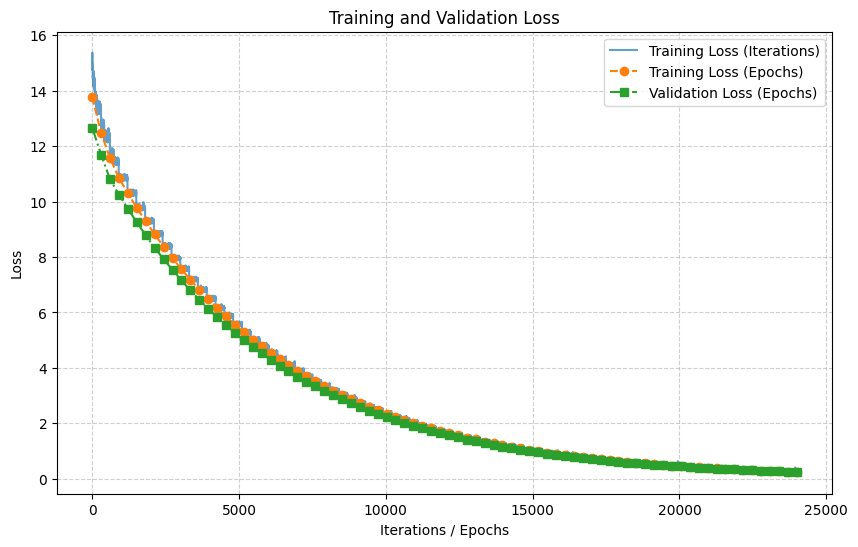

In [11]:
num_masks = 3
connection_ratios = [0.4, 0.5, 0.6]
encoder_with_classifier = EncoderWithClassifier(num_masks, connection_ratios)

# Step 1: Pretrain the encoder and classifier on MNIST
print("Pretraining Encoder and Classifier on MNIST...")
pretrain_encoder_classifier(encoder_with_classifier, loaders, epochs=80, lr=0.001)

**TESTING on Source(MNIST) and Target(USPS,SVHN) Dataset**

In [12]:
# Test function
def test_model(loader, encoder_with_classifier, path='model_MNIST.pth', dataset_name="Test Data" ):
    device_cpu = torch.device("cpu")
    model = encoder_with_classifier
    loss_func = BarrierConstrainedLoss(initial_mu=1.0, mu_decay=0.95, min_mu=0.01, epsilon=0.5)
    load_model(model, path)  # Load model before evaluation
    model.to(device_cpu)
    model.eval()

    total, correct  = 0, 0
    test_losses = []
    pci_values_list = []  # Store PCI values
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device_cpu)
            labels = labels.to(device_cpu)
            pci, PCI_normalized, selected_logits = model(images)
            pci_values_list.extend(pci.cpu().numpy().flatten())  # Flatten and store
            test_loss = loss_func(selected_logits, labels, PCI_normalized)
            test_losses.append(test_loss.item())
            _, preds = torch.max(selected_logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)


    nonzero_pci_values = [v for v in pci_values_list if v > 0] # Filter out zero PCI values
    avg_nonzero_pci = np.mean(nonzero_pci_values) if nonzero_pci_values else 0     # Compute the average PCI (ignoring zeros)
    print(f'Average Nonzero PCI for {dataset_name}: {avg_nonzero_pci:.4f}')
    if nonzero_pci_values:
      min_nonzero_pci = min(nonzero_pci_values)
      print(f'Min Nonzero PCI on {dataset_name}: {min_nonzero_pci}')

    print(f'PCI on {dataset_name}: {pci[:5, :]}')
    accuracy = 100 * correct / total
    print('Accuracy on {}: {:.2f}% ({}/{})'.format(dataset_name, accuracy, correct, total))

    return test_losses, pci_values_list


In [13]:
mnist_pci_values = []
usps_pci_values = []
svhn_pci_values = []

mnist_losses, mnist_pci_values = test_model(loaders['mnist_test'], encoder_with_classifier, dataset_name="MNIST Test Set")
usps_losses, usps_pci_values = test_model(loaders['usps_test'], encoder_with_classifier, dataset_name="USPS Test Set")
svhn_losses, svhn_pci_values = test_model(loaders['svhn_test'], encoder_with_classifier, dataset_name="SVHN Test Set")


<ipython-input-9-f0ef514ea0a3>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Average Nonzero PCI for MNIST Test Set: 3.5601
Min Nonzero PCI on MNIST Test Set: 0.2983399033546448
PCI on MNIST Test Set: tensor([[2.8884, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.0109, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.3172, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.2405, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.3731, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])
Accuracy on MNIST Test Set: 99.34% (9934/10000)
Average Nonzero PCI for USPS Test Set: 0.7558
Min Nonzero PCI on USPS Test Set: 0.6285631656646729
PCI on USPS Test Set: tensor([[0.7325, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7557, 0.0000,
         0.0000],
        [0.00

**Comparison of PCI Values Across Datasets**

<ipython-input-14-078ca15b4981>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mnist_pci_values, usps_pci_values, svhn_pci_values], labels=['MNIST', 'USPS', 'SVHN'])


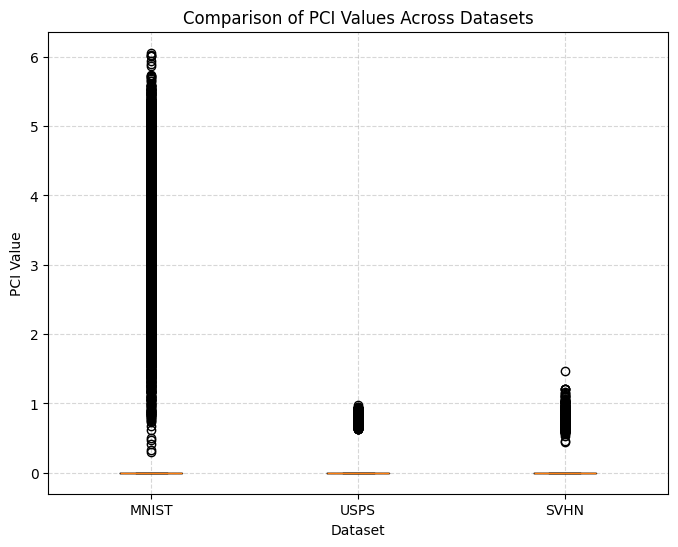

In [14]:
# Boxplot of PCI values
plt.figure(figsize=(8, 6))
plt.boxplot([mnist_pci_values, usps_pci_values, svhn_pci_values], labels=['MNIST', 'USPS', 'SVHN'])

plt.title("Comparison of PCI Values Across Datasets")
plt.ylabel("PCI Value")
plt.xlabel("Dataset")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


**Comparison of Test Losses Across Datasets**

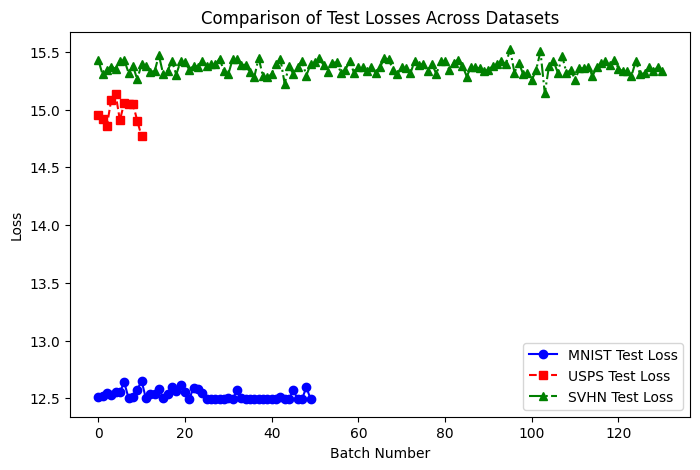

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(mnist_losses)), mnist_losses, marker='o', linestyle='-', label="MNIST Test Loss", color='b')
plt.plot(range(len(usps_losses)), usps_losses, marker='s', linestyle='--', label="USPS Test Loss", color='r')
plt.plot(range(len(svhn_losses)), svhn_losses, marker='^', linestyle='-.', label="SVHN Test Loss", color='g')

plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Comparison of Test Losses Across Datasets")
plt.legend()
plt.show()

**Comparison of the PCI and Cross-Entropy before and after Normalization**

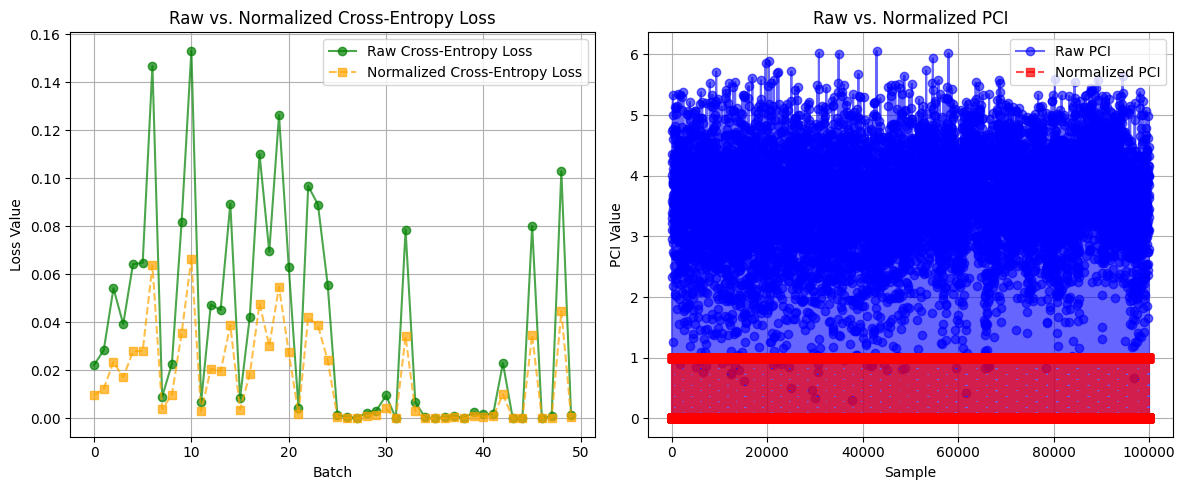

In [16]:
ce_values = []  # Stores raw Cross-Entropy Loss values
pci_values = []  # Stores raw PCI values (before normalization)
normalized_ce_values = []  # Stores normalized CE loss values
normalized_pci_values = []  # Stores normalized PCI values

def test_model(loader, encoder_with_classifier, dataset_name="Test Data"):
    device_cpu = torch.device("cpu")
    model = encoder_with_classifier
    model.to(device_cpu)
    model.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device_cpu)
            labels = labels.to(device_cpu)
            pci, PCI_normalized, selected_logits = model(images)  # Extract PCI values

            ce_loss = F.cross_entropy(selected_logits, labels)  # Compute CE loss

            # Normalize Cross-Entropy
            max_ce = torch.log(torch.tensor(selected_logits.shape[1], dtype=torch.float)).detach()
            normalized_ce = ce_loss / max_ce

            ce_values.append(ce_loss.item())  # Store raw CE values
            pci_values.extend(pci.cpu().numpy().flatten())  # Store ALL raw PCI values (not mean)
            normalized_ce_values.append(normalized_ce.item())  # Store normalized CE values
            normalized_pci_values.extend(PCI_normalized.cpu().numpy().flatten())  # Store ALL normalized PCI values

    return ce_values, pci_values, normalized_ce_values, normalized_pci_values

# Run test and store values
mnist_ce, mnist_pci, mnist_norm_ce, mnist_norm_pci = test_model(loaders['mnist_test'], encoder_with_classifier, "MNIST")


# Create x-axis indices
x_ce = np.arange(len(mnist_ce))  # X-axis for CE values
x_pci = np.arange(len(mnist_pci))  # X-axis for PCI values

plt.figure(figsize=(12, 5))

# **Plot 1: Cross-Entropy Loss (Raw vs. Normalized)**
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(x_ce, mnist_ce, label="Raw Cross-Entropy Loss", color='green', linestyle='-', marker='o', alpha=0.7)
plt.plot(x_ce, mnist_norm_ce, label="Normalized Cross-Entropy Loss", color='orange', linestyle='--', marker='s', alpha=0.7)
plt.xlabel("Batch")
plt.ylabel("Loss Value")
plt.title("Raw vs. Normalized Cross-Entropy Loss")
plt.legend()
plt.grid(True)

# **Plot 2: PCI Values (Raw vs. Normalized)**
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(x_pci, mnist_pci, label="Raw PCI", color='blue', linestyle='-', marker='o', alpha=0.6)
plt.plot(x_pci, mnist_norm_pci, label="Normalized PCI", color='red', linestyle='--', marker='s', alpha=0.7)
plt.xlabel("Sample")
plt.ylabel("PCI Value")
plt.title("Raw vs. Normalized PCI")
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()
plt.show()
